# MLP Classification on Image Features

## 0. Imports

In [1]:
from collections import deque
from typing import Literal

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import torch
import wandb

## 1. Dataset Analysis and Preprocessing

In [2]:
def load_fashion_dataset(data_dir):
    """ Loads the fashion dataset images and labels. """

    def train_val_test_split(X, y, train_size, val_size, test_size, random_seed = 0):
        """ Partitions a dataset into three sets based on given fractions. """

        if random_seed is not None:
            np.random.seed(random_seed)

        assert train_size + val_size + test_size == X.shape[0], \
                                'train_size, val_size, and test_size sizes must sum to total length.'
        assert train_size >= 0, 'train_size must be non-negative'
        assert val_size >= 0, 'val_size must be non-negative'
        assert test_size >= 0, 'test_size must be non-negative'

        assert X.shape[0] == y.shape[0], 'Expected X and y to be the same length'

        indices = np.arange(X.shape[0])
        np.random.shuffle(indices)

        X = X[indices]
        y = y[indices]

        train_end = train_size
        val_end = train_end + val_size

        X_train, X_val, X_test = X[:train_end], X[train_end:val_end], X[val_end:]
        y_train, y_val, y_test = y[:train_end], y[train_end:val_end], y[val_end:]

        return X_train, X_val, X_test, y_train, y_val, y_test

    df_train = pd.read_csv(f'{data_dir}/train.csv')
    X_train = df_train.to_numpy()[:, 1:].astype(np.uint8)
    y_train = df_train.to_numpy()[:, 0]

    df_test = pd.read_csv(f'{data_dir}/test.csv')
    X_test = df_test.to_numpy()[:, 1:].astype(np.uint8)
    y_test = df_test.to_numpy()[:, 0]

    X_train, X_val, _, y_train, y_val, _ = train_val_test_split(X_train, y_train, train_size=50000, val_size=10000, test_size=0)

    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = load_fashion_dataset('../data')

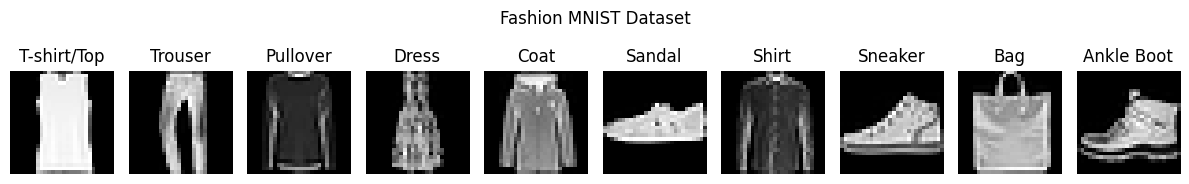

In [3]:
def visualize_dataset(X, y):

    """ Visualizes the fashion dataset. """
    fig, axs = plt.subplots(1, 10, figsize=(12, 2))
    fig.suptitle('Fashion MNIST Dataset')

    for label_idx in range(len(LABEL_MAP)):
        for sample_idx in range(len(X)):
            if y[sample_idx] != label_idx:
                continue
            axs[label_idx].imshow(X[sample_idx].reshape(28, 28), cmap='gray')
            axs[label_idx].set_title(LABEL_MAP[label_idx])
            axs[label_idx].axis('off')
            break

    plt.tight_layout()
    plt.savefig('visualize_dataset.png', bbox_inches='tight')
    plt.show()

LABEL_MAP = {
    0: 'T-shirt/Top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot'
}

visualize_dataset(X_train, y_train)

**Comments:**


The classes present in the dataset are as listed below.

```python
LABEL_MAP = {
    0: 'T-shirt/Top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot'
}
```

## 2. Model Implementation and Training

In [4]:
class ClassificationMeasures:
    """ Computes common evaluation measures for classification based tasks. """

    def __init__(self, y_true, y_pred):
        """ Initializes the class to compute on given data.

        Args:
            y_true: Array containing true values.
            y_pred: Array containing predicted values.
        """

        # Store the passed arguments
        self.y_true = y_true
        self.y_pred = y_pred

        # Initialize the classes based on y values
        self.classes = np.unique(np.concatenate((y_true, y_pred)))
        self.num_classes = self.classes.shape[0]

        # Initialize the confusion matrices to None
        self.confusion_matrices = None

    def accuracy_score(self):
        """ Computes the accuracy. """

        return np.mean(self.y_true == self.y_pred)

    def _compute_confusion_matrices(self):
        """ Computes the confusion matrices for each class. """

        confusion_matrices = np.empty((self.num_classes, 2, 2))

        # Fill the confusion matrix for each classes
        for idx, clx in enumerate(self.classes):
            # True positive
            confusion_matrices[idx, 0, 0] = np.sum((self.y_true == clx) & (self.y_pred == clx))
            # False positive
            confusion_matrices[idx, 0, 1] = np.sum((self.y_true != clx) & (self.y_pred == clx))
            # False negative
            confusion_matrices[idx, 1, 0] = np.sum((self.y_true == clx) & (self.y_pred != clx))
            # True negative
            confusion_matrices[idx, 1, 1] = np.sum((self.y_true != clx) & (self.y_pred != clx))

        return confusion_matrices

    def confusion_matrix(self):
        """ Computes the overall confusion matrix. """

        confusion_matrix = np.zeros((self.num_classes, self.num_classes), dtype=int)

        for true_idx, pred_idx in zip(self.y_true, self.y_pred):
            confusion_matrix[true_idx, pred_idx] += 1

        return confusion_matrix

    def f1_score(self, average: Literal['micro', 'macro']):
        """ Computes the f1 score. """

        # Validate the passed arguments
        assert average in ['micro', 'macro'], f'Unrecognized argument for average {average}'

        # Compute recall and precision with same method
        recall = self.recall_score(average)
        precision = self.precision_score(average)

        # Compute the F1 score
        f1 = 2 * recall * precision / (recall + precision)
        return f1

    def recall_score(self, average: Literal['micro', 'macro']):
        """ Computes the recall. """

        # Validate the passed arguments
        assert average in ['micro', 'macro'], f'Unrecognized argument for average {average}'

        # Compute confusion matrix for each class
        if self.confusion_matrices is None:
            self.confusion_matrices = self._compute_confusion_matrices()

        if average == 'micro':
            # Compute recall of pooled confusion matrix
            pooled_confusion_matrix = np.sum(self.confusion_matrices, axis=0)
            recall = pooled_confusion_matrix[0, 0] / \
                            (pooled_confusion_matrix[0, 0] + pooled_confusion_matrix[0, 1])

        elif average == 'macro':
            # Compute average over recall of individual classes
            recall = 0
            for idx in range(self.num_classes):
                denom = self.confusion_matrices[idx, 0, 0] + self.confusion_matrices[idx, 0, 1]
                if denom != 0:
                    recall += (self.confusion_matrices[idx, 0, 0] / denom)
                else:
                    recall += 1
            recall /= self.num_classes

        return recall

    def precision_score(self, average: Literal['micro', 'macro']):
        """ Computes the precision. """

        # Validate the passed arguments
        assert average in ['micro', 'macro'], f'Unrecognized argument for average {average}'

        # Compute confusion matrix for each class
        if self.confusion_matrices is None:
            self.confusion_matrices = self._compute_confusion_matrices()

        if average == 'micro':
            # Compute precision of pooled confusion matrix
            pooled_confusion_matrix = np.sum(self.confusion_matrices, axis=0)
            precision = pooled_confusion_matrix[0, 0] / \
                                (pooled_confusion_matrix[0, 0] + pooled_confusion_matrix[1, 0])

        elif average == 'macro':
            # Compute average over precision of individual classes
            precision = 0
            for idx in range(self.num_classes):
                denom = self.confusion_matrices[idx, 0, 0] + self.confusion_matrices[idx, 1, 0]
                if denom != 0:
                    precision += (self.confusion_matrices[idx, 0, 0] / denom)
                else:
                    precision += 1
            precision /= self.num_classes

        return precision

    def print_all_measures(self):
        """ Evaluates and prints all the measures. """

        print('Accuracy:', self.accuracy_score())
        print('Precision (Micro):', self.precision_score(average='micro'))
        print('Recall (Micro):', self.recall_score(average='micro'))
        print('F1 Score (Micro):', self.f1_score(average='micro'))
        print('Precision (Macro):', self.precision_score(average='macro'))
        print('Recall (Macro):', self.recall_score(average='macro'))
        print('F1 Score (Macro):', self.f1_score(average='macro'))

class FashionMNISTDataset(torch.utils.data.Dataset):
    """ Generic image, label pair dataset. """

    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return torch.tensor(self.images[idx], dtype=torch.float32), torch.tensor(self.labels[idx])

class MLPClassifier(torch.nn.Module):
    """ MLP Classifier for fashion dataset.
    Input Shape: (n, 784)
    Output Shape: (n, 10)
    """

    def __init__(self, num_layers, lr):
        super().__init__()
        if num_layers == 5:
            self.network = torch.nn.Sequential(
                torch.nn.Linear(784, 512),
                torch.nn.ReLU(),
                torch.nn.Linear(512, 256),
                torch.nn.ReLU(),
                torch.nn.Linear(256, 128),
                torch.nn.ReLU(),
                torch.nn.Linear(128, 64),
                torch.nn.ReLU(),
                torch.nn.Linear(64, 10),
                torch.nn.Softmax(dim=1)
            )
        else:
            self.network = torch.nn.Sequential(
                torch.nn.Linear(784, 512),
                torch.nn.ReLU(),
                torch.nn.Linear(512, 256),
                torch.nn.ReLU(),
                torch.nn.Linear(256, 128),
                torch.nn.ReLU(),
                torch.nn.Linear(128, 64),
                torch.nn.ReLU(),
                torch.nn.Linear(64, 32),
                torch.nn.ReLU(),
                torch.nn.Linear(32, 16),
                torch.nn.ReLU(),
                torch.nn.Linear(16, 10),
                torch.nn.Softmax(dim=1)
            )
        self.loss_function = torch.nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(self.network.parameters(), lr=lr)

    def _early_stopping(self, val_loss):
        """ Checks the suitability for early stopping of gradient descent. """

        self.val_losses.append(val_loss)

        if len(self.val_losses) == self.val_losses.maxlen:

            midpoint = self.val_losses.maxlen // 2
            previous_loss_pattern = np.mean(list(self.val_losses)[:midpoint])
            current_loss_pattern = np.mean(list(self.val_losses)[midpoint:])

            if current_loss_pattern > previous_loss_pattern:
                return True

        return False

    def evaluate(self, dataset, verbose = False, wandb_log = False):
        """ Evaluates the model on a dataset. """

        y_true = dataset.labels
        y_pred = self.predict(dataset)

        cls_measures = ClassificationMeasures(y_true, y_pred)
        accuracy = cls_measures.accuracy_score()
        precision = cls_measures.precision_score(average='macro')
        recall = cls_measures.recall_score(average='macro')
        f1_score = cls_measures.f1_score(average='macro')
        confusion_matrix = cls_measures.confusion_matrix()
        confusion_matrix_plot = wandb.plot.confusion_matrix(y_true=y_true, preds=y_pred, class_names=list(LABEL_MAP.values()))

        if verbose:
            print(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1_score}')
            print(f'Confusion matrix:\n{confusion_matrix}')
        if wandb_log:
            wandb.log({
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1_score': f1_score,
                'confusion_matrix': confusion_matrix_plot
            })

    def fit(self, train_dataset, val_dataset, verbose = False, wandb_log = False):
        """ Fits the model for given training data, using validation data for early stopping. """

        train_dataloader = torch.utils.data.DataLoader(
            train_dataset,
            batch_size=32,
            shuffle=True
        )
        val_dataloader = torch.utils.data.DataLoader(
            val_dataset,
            batch_size=32
        )

        self.val_losses = deque(maxlen=4)

        for epoch in range(15):

            self.network.train()
            train_loss = self.pass_epoch(train_dataloader, train=True)

            self.network.eval()
            val_loss = self.pass_epoch(val_dataloader)

            if verbose:
                print(f'Epoch {epoch}, Train Loss: {train_loss}, Val Loss: {val_loss}')
            if wandb_log:
                wandb.log({
                    'train_loss': train_loss,
                    'val_loss': val_loss
                })

            if self._early_stopping(val_loss):
                break

        return self

    def forward(self, X):
        """ Forward pass over the network. """

        return self.network(X)

    def pass_epoch(self, dataloader, train = False) -> float:
        """ Iterates over the dataset, optionally trains the model and returns the total loss. """

        self.network = self.network.cuda()

        loss = 0
        for _, (x, y) in enumerate(dataloader):

            x = x.to('cuda')
            y = y.to('cuda')
            y_pred = self.forward(x)

            loss_batch = self.loss_function(y_pred, y)
            loss += loss_batch.detach().cpu().item()

            if train:
                loss_batch.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()

        self.network = self.network.cpu()

        loss /= len(dataloader)
        return loss

    def predict(self, X):
        """ Returns the class indices with the highest probability. """

        with torch.inference_mode():

            if isinstance(X, torch.Tensor):
                y = self.forward(X)

            elif isinstance(X, torch.utils.data.Dataset):
                y = []
                self.network = self.network.cuda()
                dataloader = torch.utils.data.DataLoader(X, batch_size=32)

                for _, (x, _) in enumerate(dataloader):
                    x = x.to('cuda')
                    y_pred = self.forward(x).cpu()
                    y.append(y_pred)

                y = torch.cat(y, dim=0)
                self.network = self.network.cpu()

            else:
                raise ValueError('Expected a Tensor or Dataset')

        return y.argmax(axis=1).unsqueeze(1).numpy().reshape((-1))

In [5]:
def canny_edge_detector(images, threshold1, threshold2):
    """ Runs Canny edge detector on an array of grayscale images. """

    return np.array([ cv2.Canny(image, threshold1=threshold1, threshold2=threshold2)[:, 0] for image in images ])

def orb_feature_descriptor(images, nfeatures):
    """ Runs ORB feature detection on an array of grayscale images. """

    features = []
    orb = cv2.ORB_create(nfeatures=nfeatures, edgeThreshold=0)
    for image in images:
        keypoints, descriptors = orb.detectAndCompute(image.reshape((28, 28)), None)
        descriptors = descriptors.reshape((-1))[:784]
        descriptors = np.pad(descriptors, (0, 784 - descriptors.shape[0]))
        features.append(descriptors)
    return np.array(features)

In [6]:
def hyperparameter_tuning_raw():
    """ Hyperparameter tuning for model predicting based on raw images. """

    def train_worker_raw():
        """ Trains a MLP classifier on raw image. """

        wandb.init()
        model = MLPClassifier(
            num_layers=wandb.config.num_layers,
            lr=wandb.config.lr,
        )

        train_dataset = FashionMNISTDataset(X_train, y_train)
        val_dataset = FashionMNISTDataset(X_val, y_val)
        test_dataset = FashionMNISTDataset(X_test, y_test)
        model.fit(train_dataset, val_dataset, wandb_log=True)
        model.evaluate(test_dataset, wandb_log=True)

    sweep_config_raw = {
        'name': 'raw-image',
        'method': 'grid',
        'metric': { 'name': 'val_loss', 'goal': 'minimize' },
        'parameters': {
            'num_layers': { 'values': [5, 7] },
            'lr': { 'values': [1e-6, 1e-5] },
        }
    }

    sweep_id_raw = wandb.sweep(sweep_config_raw, project='cv-s25-a1-mlp-classification')
    wandb.agent(sweep_id_raw, train_worker_raw)
    wandb.finish()
    shutil.rmtree('wandb')

def hyperparameter_tuning_canny():
    """ Hyperparameter tuning for model predicting based on Canny edges. """

    def train_worker_canny():
        """ Trains a MLP classifier on Canny edges. """

        wandb.init()
        model = MLPClassifier(
            num_layers=wandb.config.num_layers,
            lr=wandb.config.lr,
        )

        _X_train = canny_edge_detector(X_train, wandb.config.threshold1, wandb.config.threshold2)
        _X_val = canny_edge_detector(X_val, wandb.config.threshold1, wandb.config.threshold2)
        _X_test = canny_edge_detector(X_test, wandb.config.threshold1, wandb.config.threshold2)

        train_dataset = FashionMNISTDataset(_X_train, y_train)
        val_dataset = FashionMNISTDataset(_X_val, y_val)
        test_dataset = FashionMNISTDataset(_X_test, y_test)
        model.fit(train_dataset, val_dataset, wandb_log=True)
        model.evaluate(test_dataset, wandb_log=True)

    sweep_config_canny = {
        'name': 'canny-edge',
        'method': 'grid',
        'metric': { 'name': 'val_loss', 'goal': 'minimize' },
        'parameters': {
            'num_layers': { 'values': [5, 7] },
            'lr': { 'values': [1e-6, 1e-5] },
            'threshold1': { 'values': [150, 300] },
            'threshold2': { 'values': [150, 300] },
        }
    }

    sweep_id_canny = wandb.sweep(sweep_config_canny, project='cv-s25-a1-mlp-classification')
    wandb.agent(sweep_id_canny, train_worker_canny)
    wandb.finish()
    shutil.rmtree('wandb')

def hyperparameter_tuning_orb():
    """ Hyperparameter tuning for model predicting based on ORB descriptors. """

    def train_worker_orb():
        """ Trains a MLP classifier on ORB descriptors. """

        wandb.init()
        model = MLPClassifier(
            num_layers=wandb.config.num_layers,
            lr=wandb.config.lr,
        )

        _X_train = orb_feature_descriptor(X_train, wandb.config.nfeatures)
        _X_val = orb_feature_descriptor(X_val, wandb.config.nfeatures)
        _X_test = orb_feature_descriptor(X_test, wandb.config.nfeatures)

        train_dataset = FashionMNISTDataset(_X_train, y_train)
        val_dataset = FashionMNISTDataset(_X_val, y_val)
        test_dataset = FashionMNISTDataset(_X_test, y_test)
        model.fit(train_dataset, val_dataset, wandb_log=True)
        model.evaluate(test_dataset, wandb_log=True)

    sweep_config_orb = {
        'name': 'orb-descriptor',
        'method': 'grid',
        'metric': { 'name': 'val_loss', 'goal': 'minimize' },
        'parameters': {
            'num_layers': { 'values': [5, 7] },
            'lr': { 'values': [1e-6, 1e-5] },
            'nfeatures': { 'values': [10, 20] }
        }
    }

    sweep_id_orb = wandb.sweep(sweep_config_orb, project='cv-s25-a1-mlp-classification')
    wandb.agent(sweep_id_orb, train_worker_orb)
    wandb.finish()
    shutil.rmtree('wandb')

# hyperparameter_tuning_raw()
# hyperparameter_tuning_canny()
# hyperparameter_tuning_orb()

## 3. Plots and Performance Visualizations

### 3.1 Validation Loss for Different Hyperparameters

1. **Model 1 (Raw Image):**

<img src="raw_image.png" alt="raw_image" height="250"/>

2. **Model 2 (Canny Edge):**

<img src="canny_edge.png" alt="canny_edge" height="250"/>

3. **Model 3 (ORB Descriptor):**

<img src="orb_descriptor.png" alt="orb_descriptor" height="250"/>

### 3.2 Convergence Behavior of Best Models

- **Model 1 (Raw Image):** Gets progressively better with losses.

- **Model 2 (Canny Edge):** Converges very quickly, presumably because of lesser preprocessing load and sparse input.

- **Model 3 (ORB Descriptor):** Displays poor learning curves across all variants.

<img src="train_loss.png" alt="train_loss" width="450"/>
<img src="val_loss.png" alt="val_loss" width="450"/>

### 3.3 Confusion Matrix of Best Models

- **Ankle Boot, Sandal, Sneaker, Trouser:** All models seem to get the footwear/legwear right.

- **Bag, Dress:** All models, except Model 3, classify them correctly.

- **Coat, Pullover, Shirt, T-Shirt/Top:** All models poorly classify the topwear.

<img src="confusion_matrix.png" alt="confusion_matrix" width="600"/>

### 3.4 Performance Metrics for Best Models

| Model           | Accuracy | F1 Score | Precision | Recall |
|-----------------|----------|----------|-----------|--------|
| Raw Image       | 0.88     | 0.88     | 0.88      | 0.88   |
| Canny Edge      | 0.85     | 0.85     | 0.85      | 0.85   |
| ORB Descriptor  | 0.66     | 0.64     | 0.66      | 0.61   |

- The classifier gives better (and comparable) results with raw images and edges as input, compared to descriptors.

- This indicates that the images do not have meaningful (ORB) features to base the classification task upon.

- There is no meaningful variation among the different performance metrics. All convey the same trend.

## 4. Analysis and Logical Comparison

**Qn. Discuss the performance differences between the three models based on their input features. What kinds of features seem to be more helpful for classification?**

- It is apparent that the model in hand learns more easily with the full image as input. Note that the edges are also equivalent to the image, as they are of the same shape and retain most of the spatial relations in the original image.

- The ORB descriptors, on the other hand, devote a 32 length vector to each keypoint, which maybe an overkill for a low resolution 28x28 image.

- Further, the number of ORB descriptors are variable in nature, subject to keypoint detection. The leftover entries have to be filled with zero for producing a constant length input vector.

**Qn. Explain how the choice of feature extraction impacts the MLP’s ability to learn and generalize, and identify scenarios where each transformation might perform better.**

- MLPs are sensitive to the input indices. They don't learn invariance or equivariance out of the box. We can relate this fact with the poor performance with ORB descriptors where the detected keypoints do not have an inherent ordering. A low resolution image (raw or edge), on the other hand, cannot have much variation in the indices.

- Listed below are a few scenarios where each of the method perform better than the rest.

    i. Raw Image: When images lack both clear edges and sufficient keypoints.

    ii. Edge Image: When images have high intra-shape intensity variation and the outputs depend only on the constituent shapes.

    iii. Descriptor: When the outputs depend only on specific keypoints, that have high variance due to translations and rotations in the images.